In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import numpy as np
import itertools
from tabulate import tabulate

from action_utils import *

In [3]:
main_df = pd.read_csv("datasets/my_uspto/supervised_zinc_gin/dataset.csv", index_col=0)

In [4]:
N = 50000

# take N samples of it
np.random.seed(42)
print(main_df.shape)
elements_to_fetch = np.random.randint(0, main_df.shape[0], size=(N,))
main_df = main_df.iloc[elements_to_fetch]
print(main_df.shape)

(3976954, 10)
(50000, 10)


# Neural Network!

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 23413.3887
Epoch 2, Loss: 13398.2363
Epoch 3, Loss: 4429.3608
Epoch 4, Loss: 976.3035
Epoch 5, Loss: 357.7242
Epoch 6, Loss: 291.2738
Epoch 7, Loss: 276.5722
Epoch 8, Loss: 280.6163
Epoch 9, Loss: 275.0232
Epoch 10, Loss: 270.6531

FINAL TEST LOSS: 70.58915710449219


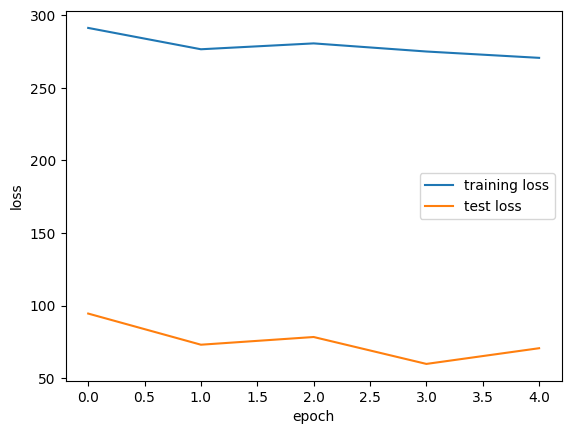

CPU times: user 5.7 s, sys: 271 ms, total: 5.98 s
Wall time: 2.7 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [9]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out
    

def train(X, Y, num_hidden=1, hidden_size=50, lr=1e-2, bs=64, epochs=100):
    train_X = torch.Tensor(X[:int(X.shape[0]*0.7)]).to(device)
    train_Y = torch.Tensor(Y[:int(Y.shape[0]*0.7)]).to(device)

    test_X = torch.Tensor(X[int(X.shape[0]*0.7):]).to(device)
    test_Y = torch.Tensor(Y[int(Y.shape[0]*0.7):]).to(device)
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        for i in range(0, train_X.shape[0], batch_size):
            model.train()
            # Forward pass
            outputs = model(train_X[i:i+batch_size])
            loss = criterion(outputs, train_Y[i:i+batch_size])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_list.append(loss.item())
        print ('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        
        model.eval()
        test_loss.append(criterion(model(test_X), test_Y).item()) 
    print("\nFINAL TEST LOSS:", test_loss[-1])
        
    plt.plot(loss_list[5:], label="training loss")
    plt.plot(test_loss[5:], label="test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
        
    return model
        
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [10]:
from torchdrug import data

In [11]:
model_name = "models/zinc2m_gin.pth"
clintox_gin = torch.load(model_name).to(device)

In [12]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def clintox_gin_mol_embedding(smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = clintox_gin(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu().numpy()

def clintox_gin_atom_embedding(smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = clintox_gin(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def clinton_gin_action_embedding(action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
#     print(clintox_gin_mol_embedding(rsub).shape)
#     print(clintox_gin_atom_embedding(rsig, rcen).shape)
#     print(clintox_gin_mol_embedding(rsig).shape)
#     print(clintox_gin_mol_embedding(psub).shape)
#     print(clintox_gin_atom_embedding(psig, pcen).shape)
#     print(clintox_gin_mol_embedding(psig).shape)
    embedding = np.concatenate([
#                         clintox_gin_mol_embedding(rsub), 
#                         clintox_gin_atom_embedding(rsig, rcen) / 5, 
                        clintox_gin_mol_embedding(rsig), 
#                         clintox_gin_mol_embedding(psub), 
#                         clintox_gin_atom_embedding(psig, pcen) / 5, 
                        clintox_gin_mol_embedding(psig)
                    ], axis=1)
    return embedding

In [13]:
batch_size = 64
X = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(np.concatenate([clintox_gin_mol_embedding(reactants), clintox_gin_mol_embedding(products)], axis=1))
X = np.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  7%|████▌                                                          | 57/782 [00:20<04:08,  2.91it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
 50%|██████████████████████████████▊                               | 388/782 [02:16<02:12,  2.98it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
 51%|███████████████████████████████▋                              | 399/782 [02:20<02:12,  2.89it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
100%|██████████████████████████████████████████████████████████████| 782/782 [04:33<00:00,  2.86it/s]


(50000, 256)

In [14]:
batch_size = 64
Y = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    Y.append(clinton_gin_action_embedding(main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = np.concatenate(Y)
Y.shape

100%|██████████████████████████████████████████████████████████████| 782/782 [03:10<00:00,  4.10it/s]


(50000, 256)

### MSE training

In [15]:
model = train(X, Y, hidden_size=500, num_hidden=2, lr=1e-3, epochs=30)

Epoch 1, Loss: 0.0392
Epoch 2, Loss: 0.0337
Epoch 3, Loss: 0.0307
Epoch 4, Loss: 0.0270
Epoch 5, Loss: 0.0249
Epoch 6, Loss: 0.0238
Epoch 7, Loss: 0.0215
Epoch 8, Loss: 0.0194
Epoch 9, Loss: 0.0192
Epoch 10, Loss: 0.0190
Epoch 11, Loss: 0.0163
Epoch 12, Loss: 0.0158
Epoch 13, Loss: 0.0156
Epoch 14, Loss: 0.0137
Epoch 15, Loss: 0.0137
Epoch 16, Loss: 0.0135
Epoch 17, Loss: 0.0143
Epoch 18, Loss: 0.0135
Epoch 19, Loss: 0.0123
Epoch 20, Loss: 0.0118
Epoch 21, Loss: 0.0112
Epoch 22, Loss: 0.0109
Epoch 23, Loss: 0.0107
Epoch 24, Loss: 0.0106
Epoch 25, Loss: 0.0099
Epoch 26, Loss: 0.0106
Epoch 27, Loss: 0.0098
Epoch 28, Loss: 0.0091
Epoch 29, Loss: 0.0123
Epoch 30, Loss: 0.0091

FINAL TEST LOSS: 0.024564296007156372


torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [16]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)

action_dataset = action_dataset.loc[action_dataset["reactant_works"] & action_dataset["reactant_tested"] & action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset.shape

action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]

print(action_dataset.shape)

action_embeddings = []
for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
    action_embeddings.append(clinton_gin_action_embedding(action_dataset.iloc[i:i+batch_size]))
action_embeddings = np.concatenate(action_embeddings)
print(action_embeddings.shape)

(88995, 8)


  7%|████▏                                                         | 93/1391 [00:24<05:16,  4.11it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 61%|█████████████████████████████████████                        | 845/1391 [03:33<02:20,  3.89it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
 63%|██████████████████████████████████████▍                      | 877/1391 [03:42<02:23,  3.58it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Cr`
  warnings.warn("Unknown value `%s`" % x)
 75%|█████████████████████████████████████████████▏              | 1047/1391 [04:31<01:30,  3.81it/s]/home/abhor/min

(88995, 256)


### Back to modeling

In [17]:
correct_indices = []
action_embedding_indices = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    
    indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
    action_embedding_indices.append(indices_used_for_data)

    applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
    correct_indices.append((applicable_actions_df.index == row.name).argmax())
    
    assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"

100%|██████████████████████████████████████████████████████████| 50000/50000 [29:49<00:00, 27.94it/s]


In [18]:
def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/(np.linalg.norm(emb_for_comparison, axis=1)*np.linalg.norm(pred))

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

def get_top_k_indices(pred, emb_for_comparison, correct_index, distance="euclidean", k=1):
    return get_ranking(pred, emb_for_comparison, correct_index, distance, k)
    
pred = model(torch.Tensor(X[40000:]).to(device)).detach().cpu().numpy()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[40000+i]], correct_indices[40000+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    l.append(rank)
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|█████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 886.98it/s]

68.2398(1699.503) +- 206.87088991919572  


In [147]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

In [148]:
# https://github.com/mangye16/ReID-Survey
def euclidean_dist(x, y):
    """
    Args:
      x: pytorch Variable, with shape [m, d]
      y: pytorch Variable, with shape [n, d]
    Returns:
      dist: pytorch Variable, with shape [m, n]
    """
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

def cosine_dist(x, y):
    xy = x.matmul(y.t())

    m, n = x.size(0), y.size(0)
    xx = torch.linalg.norm(x, axis=1).expand(n, m).t()
    yy = torch.linalg.norm(y, axis=1).expand(m, n)
    
    return 1 - xy / (xx*yy)


def softmax_weights(dist, mask):
    max_v = torch.max(dist * mask, dim=1, keepdim=True)[0]
    diff = dist - max_v
    Z = torch.sum(torch.exp(diff) * mask, dim=1, keepdim=True) + 1e-6 # avoid division by zero
    W = torch.exp(diff) * mask / Z
    return W

class WeightedRegularizedTriplet(object):
    def __init__(self, dist="euclidean"):
        self.ranking_loss = nn.SoftMarginLoss()
        self.dist = dist

    def __call__(self, global_feat, labels):
        if self.dist=="euclidean":
            dist_mat = euclidean_dist(global_feat, global_feat)
        elif self.dist=="cosine":
            dist_mat = cosine_dist(global_feat, global_feat) ####### NEEEDS TO BE CHANGED!!!!!!!!!!!

        N = dist_mat.size(0)
        # shape [N, N]
        is_pos = labels.expand(N, N).eq(labels.expand(N, N).t()).float()
        is_neg = labels.expand(N, N).ne(labels.expand(N, N).t()).float()

        # `dist_ap` means distance(anchor, positive)
        # both `dist_ap` and `relative_p_inds` with shape [N, 1]
        dist_ap = dist_mat * is_pos
        dist_an = dist_mat * is_neg

        weights_ap = softmax_weights(dist_ap, is_pos)
        weights_an = softmax_weights(-dist_an, is_neg)
        furthest_positive = torch.sum(dist_ap * weights_ap, dim=1)
        closest_negative = torch.sum(dist_an * weights_an, dim=1)

        y = furthest_positive.new().resize_as_(furthest_positive).fill_(1)
        loss = self.ranking_loss(closest_negative - furthest_positive, y)

        return loss

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
7.103463(1)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤════════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                   │
╞═════

2.434199(12)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 4.22247 │ 0.798994 │ 204.7290(1699.503) +- 401.4430 │ 86.5187(1699.503) +- 212.2628 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

2.408067(13)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤

6.700424(24)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 4.04892 │ 0.816683 │ 186.0026(1699.503) +- 395.4205 │ 75.8868(1699.503) +- 201.9507 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

7.051097(25)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤

6.750460(36)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.83188 │ 0.837315 │ 151.4684(1699.503) +- 363.3568 │ 63.3155(1699.503) +- 189.7050 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

6.650508(37)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤

7.128487(48)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.87307 │ 0.828527 │ 174.9679(1699.503) +- 382.2638 │ 65.1409(1699.503) +- 191.6625 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

6.585696(49)  
######################################################################
# Margin = 10000 | distance_metric = cosine | topk distance = cosine #
######################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤

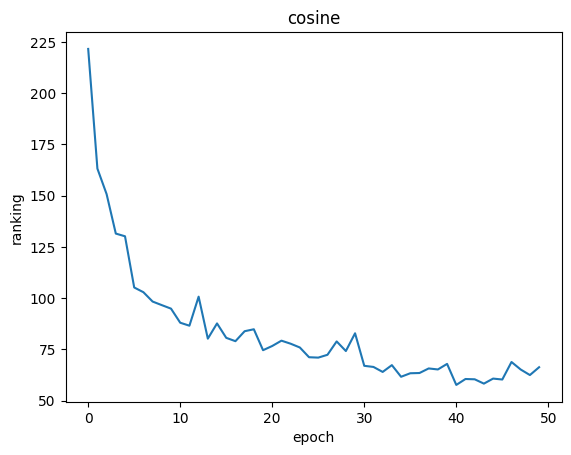

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0.428104(1)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤════════╤══════════╤════════════════════════════════╤════════════════════════════════╕
│       │   rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)           

0.321628(12)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪════════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.70478 │ 0.848183 │ 108.0341(1699.503) +- 274.0987 │ 63.3538(1699.503) +- 176.4067 │
╘═══════╧═════════╧══════════╧════════════════════════════════╧═══════════════════════════════╛

0.330400(13)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤════════

╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.66592 │ 0.853142 │ 97.1762(1699.503) +- 261.6207 │ 56.7711(1699.503) +- 164.0258 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

0.338060(24)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤════════╤══════════╤════════════════════════════════╤═══════════════════════════════╕
│       │   rMSE │   Cosine │ Rank(euclid)                   │ Rank(cosine)                  │
╞═══════╪════════╪══════════╪════════════════════════════════╪══════════════════════════

1.051627(35)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.55117 │ 0.863043 │ 96.9504(1699.503) +- 269.4078 │ 50.7350(1699.503) +- 154.7645 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

0.339120(36)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤══

1.039884(47)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤═════════╤══════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │    rMSE │   Cosine │ Rank(euclid)                  │ Rank(cosine)                  │
╞═══════╪═════════╪══════════╪═══════════════════════════════╪═══════════════════════════════╡
│ 0:256 │ 3.50861 │ 0.867741 │ 81.4920(1699.503) +- 241.3417 │ 44.7471(1699.503) +- 146.6006 │
╘═══════╧═════════╧══════════╧═══════════════════════════════╧═══════════════════════════════╛

0.346492(48)  
############################################################################
# Margin = 10000 | distance_metric = euclidean | topk distance = euclidean #
############################################################################
╒═══════╤════════╤══════════╤═══

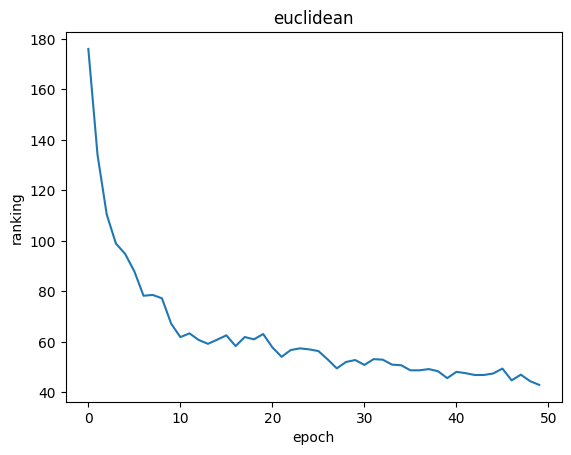

CPU times: user 1d 9h 31min 45s, sys: 1h 59min 9s, total: 1d 11h 30min 55s
Wall time: 3h 13min 44s


In [149]:
%%time
%matplotlib inline
train_X = torch.Tensor(X[train_idx]).to(device)
train_Y = torch.Tensor(Y[train_idx]).to(device)

test_X = torch.Tensor(X[test_idx]).to(device)
test_Y = torch.Tensor(Y[test_idx]).to(device)

hidden_size, num_hidden, lr, epochs, batch_size = 512, 3, 1e-3, 50, 128


for margin, distance_metric in itertools.product([10000], ["cosine", "euclidean"]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()

    loss_list = []
    test_loss = []
    ultra_rank_list = []

    # Train the model
    for epoch in range(epochs):
        model.train()
        for i in range(0, train_X.shape[0], batch_size):
            # Forward pass
            outputs = model(train_X[i:i+batch_size])

            # Calc negatives
            negatives = []
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                top = get_top_k_indices(outputs[_i].detach().cpu().numpy(), act_emb_for_i, correct_index, distance=distance_metric, k=50)
                
                negatives.append(act_emb_for_i[top])
            negatives = torch.Tensor(np.concatenate(negatives, axis=0)).to(device)
            # Calc loss
            inputs = torch.concat([outputs, train_Y[i:i+batch_size], negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(train_Y[i:i+batch_size].shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list.append(loss.item())
        print ('{:.6f}({})'.format(loss.item(), epoch+1), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# Margin = {margin} | distance_metric = {distance_metric} | topk distance = {distance_metric} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_X).detach().cpu().numpy() 
            true = test_Y.detach().cpu().numpy()

            metric_df = pd.DataFrame(columns=["rMSE", "Cosine", "Rank(euclid)", "Rank(cosine)"])

            # Print Test metrics
            mse_list = []
            cosine_list = []
            idx_list = []
            mse_list.append( (((pred-true)**2).sum(axis=1)**0.5).mean() )
            cosine_list.append(((pred*true).sum(axis=1) / np.linalg.norm(pred, axis=1) / np.linalg.norm(true, axis=1)).mean())    
            idx_list.append(f"0:{Y.shape[1]}")

            # Print Test metric - Rank
            d = {}
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                    l.append(rank)
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                d[dist] = rank_list

            metric_df["rMSE"] = mse_list
            metric_df["Cosine"] = cosine_list
            metric_df["Rank(euclid)"] = d["euclidean"]
            metric_df["Rank(cosine)"] = d["cosine"]
            ultra_rank_list.append(np.mean(l))
            metric_df.index = idx_list
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
    plt.plot(ultra_rank_list)
    plt.title(distance_metric)
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.show()